In [1]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install GPy
import pandas as pd
import zipfile
import urllib.request
import os
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla T4'

In [0]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [0]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, learn_rate, weight_decay):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(n_feature, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, 2*n_output)
        
        self.loss_func = log_gaussian_loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learn_rate, weight_decay=weight_decay)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.forward(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)/x.shape[0]
        
        loss.backward()
        self.optimizer.step()

        return loss

In [0]:
def eval_ensemble(x, y, ensemble):
    
    x, y = to_variable(var=(x, y), cuda=True)
        
    means, stds = [], []
    for net in ensemble:
        output = net(x)
        means.append(output[:, :1, None])
        stds.append(output[:, 1:, None].exp())
            
    means, stds = torch.cat(means, 2), torch.cat(stds, 2)
    mean = means.mean(dim=2)
    std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
    loss = log_gaussian_loss(mean, y, std, 1)/len(x)
    
    rmse = ((mean - y)**2).mean()**0.5

    return loss, rmse

In [7]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]


nb_epochs, batch_size = 1000, len(x_train)

fit_loss_train = np.zeros(nb_epochs)
best_net, best_loss = None, float('inf')
num_nets, nets, losses = 10, [], []

for n in range(num_nets):
    net = Net(n_feature=1, n_hidden=200, n_output=1, learn_rate=1e-2, weight_decay=1e-1).cuda()
    
    sub_idx = np.random.choice(np.arange(0, len(x_train)), size = (int(len(x_train)*0.5),), replace=True)
    x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]
    
    for i in range(nb_epochs):

        loss = net.fit(x_train_sub, y_train_sub)

        if i % 200 == 0:
            print('Network %2d, Epoch %4d, Train loss = %6.3f' % (len(nets)+1, i, loss.cpu().data.numpy()))
            
    nets.append(copy.deepcopy(net))
    

Network  1, Epoch    0, Train loss =  1.398
Network  1, Epoch  200, Train loss = -0.072
Network  1, Epoch  400, Train loss =  0.041
Network  1, Epoch  600, Train loss = -0.088
Network  1, Epoch  800, Train loss = -0.259
Network  2, Epoch    0, Train loss =  2.977
Network  2, Epoch  200, Train loss = -0.063
Network  2, Epoch  400, Train loss =  0.440
Network  2, Epoch  600, Train loss =  0.008
Network  2, Epoch  800, Train loss = -0.273
Network  3, Epoch    0, Train loss =  1.500
Network  3, Epoch  200, Train loss =  0.138
Network  3, Epoch  400, Train loss =  0.007
Network  3, Epoch  600, Train loss = -0.075
Network  3, Epoch  800, Train loss = -0.124
Network  4, Epoch    0, Train loss =  1.840
Network  4, Epoch  200, Train loss = -0.044
Network  4, Epoch  400, Train loss = -0.209
Network  4, Epoch  600, Train loss = -0.253
Network  4, Epoch  800, Train loss = -0.275
Network  5, Epoch    0, Train loss =  2.059
Network  5, Epoch  200, Train loss =  0.016
Network  5, Epoch  400, Train lo

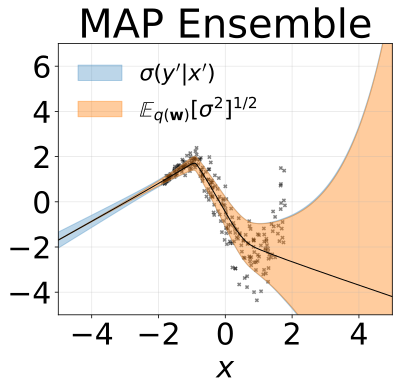

In [8]:
values, noises = [], []
for net in nets:
    preds = net(torch.linspace(-5, 5, 200)[:, None].cuda())
    values.append(preds[:, 0].cpu().data.numpy())
    noises.append(preds[:, 1].exp().cpu().data.numpy())
      
values = np.array(values).reshape(num_nets, 200)
means, epistemic = values.mean(axis = 0), values.var(axis = 0)**0.5
noises = np.array(noises)
aleatoric = (noises**2).mean(axis = 0)**0.5

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = r"$\sigma(y'|x')$")
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = r'$\mathbb{E}_{q(\mathbf{w})}[\sigma^2]^{1/2}$')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('MAP Ensemble', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.legend(loc = 2, fontsize = 22, frameon=False)
plt.savefig('map_hetero.pdf', bbox_inches = 'tight')

files.download("map_hetero.pdf")

plt.show()

# UCI dataset fitting

In [0]:
class Net_UCI(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, learn_rate, weight_decay):
        super(Net_UCI, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, 2*n_output)
        
        self.loss_func = log_gaussian_loss
        self.optimizer = torch.optim.SGD(self.parameters(), lr=learn_rate, weight_decay=weight_decay)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)
        return x
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.forward(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)/x.shape[0]
        
        loss.backward()
        self.optimizer.step()

        return loss

In [0]:
def train_ensemble(data, n_splits, num_epochs, num_nets, num_hidden, learn_rate, weight_decay, data_fraction, log_every):
    
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for j, idx in enumerate(kf.split(data)):
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        batch_size = len(x_train)

        fit_loss_train = np.zeros(num_epochs)
        best_net, best_loss = None, float('inf')
        nets = []

        for n in range(num_nets):
            net = Net_UCI(n_feature=in_dim, n_hidden=num_hidden, n_output=1, learn_rate=learn_rate, weight_decay=weight_decay).cuda()

            sub_idx = np.random.choice(np.arange(0, len(x_train)), size = (int(len(x_train)*data_fraction),), replace=True)
            x_train_sub, y_train_sub = x_train[sub_idx], y_train[sub_idx]

            for i in range(num_epochs):

                loss = net.fit(x_train_sub, y_train_sub)

                if log_every is not False and (i % log_every == 0 or i == num_epochs - 1) and len(nets) > 0:
                    train_loss, train_rmse = eval_ensemble(x_train, y_train, nets)
                    test_loss, test_rmse = eval_ensemble(x_test, y_test, nets)
                    print('Epoch %3d, network %2d, Loss train/test %.3f/%.3f, RMSE train/test %.3f/%.3f' % \
                          (i+1, len(nets), train_loss.cpu().data.numpy(), test_loss.cpu().data.numpy(),
                          train_rmse.cpu().data.numpy(), test_rmse.cpu().data.numpy()))

            nets.append(copy.deepcopy(net))


        train_loss, train_rmse = eval_ensemble(x_train, y_train, nets)
        test_loss, test_rmse = eval_ensemble(x_test, y_test, nets)

        train_logliks.append(-train_loss.cpu().data.numpy() - np.log(y_stds)[0])
        test_logliks.append(-test_loss.cpu().data.numpy() - np.log(y_stds)[0])

        train_rmses.append(y_stds[0]*train_rmse.cpu().data.numpy())
        test_rmses.append(y_stds[0]*test_rmse.cpu().data.numpy())

    print('Train log. lik. = %7.3f +/- %.3f' % (np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %7.3f +/- %.3f' % (np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %7.3f +/- %.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %7.3f +/- %.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))
    
    return nets

# Housing dataset

In [32]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

--2019-05-17 22:39:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [application/x-httpd-php]
Saving to: ‘housing.data.28’

housing.data.28     100%[===================>]  47.93K   170KB/s    in 0.3s    

2019-05-17 22:39:34 (170 KB/s) - ‘housing.data.28’ saved [49082/49082]



In [33]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-2, weight_decay=1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -2.040 +/- 0.010
Test  log. lik. =  -2.080 +/- 0.151
Train RMSE      =   5.844 +/- 0.123
Test  RMSE      =   5.807 +/- 1.171


# Concrete compressive dataset

In [34]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 22:40:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124928 (122K) [application/x-httpd-php]
Saving to: ‘Concrete_Data.xls.6’

Concrete_Data.xls.6 100%[===================>] 122.00K   290KB/s    in 0.4s    

2019-05-17 22:40:31 (290 KB/s) - ‘Concrete_Data.xls.6’ saved [124928/124928]



(1030, 9)

In [38]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-1, weight_decay=0*1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -2.849 +/- 0.085
Test  log. lik. =  -2.864 +/- 0.087
Train RMSE      =   9.078 +/- 0.481
Test  RMSE      =   9.407 +/- 0.969


# Energy efficiency dataset

In [21]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 22:14:45--  http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76189 (74K) [application/x-httpd-php]
Saving to: ‘ENB2012_data.xlsx.1’

ENB2012_data.xlsx.1 100%[===================>]  74.40K   234KB/s    in 0.3s    

2019-05-17 22:14:46 (234 KB/s) - ‘ENB2012_data.xlsx.1’ saved [76189/76189]



(768, 10)

In [22]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-2, weight_decay=1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -1.490 +/- 0.113
Test  log. lik. =  -1.501 +/- 0.107
Train RMSE      =   2.633 +/- 0.121
Test  RMSE      =   2.638 +/- 0.269


# Power dataset

In [23]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)
data.shape

--2019-05-17 22:15:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3674852 (3.5M) [application/x-httpd-php]
Saving to: ‘CCPP.zip.1’

CCPP.zip.1          100%[===================>]   3.50M  3.13MB/s    in 1.1s    

2019-05-17 22:15:14 (3.13 MB/s) - ‘CCPP.zip.1’ saved [3674852/3674852]



(9568, 5)

In [24]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-2, weight_decay=1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -2.034 +/- 0.012
Test  log. lik. =  -2.038 +/- 0.020
Train RMSE      =   4.498 +/- 0.053
Test  RMSE      =   4.500 +/- 0.147


# Red wine dataset

In [25]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 22:15:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv.2’

winequality-red.csv 100%[===================>]  82.23K   291KB/s    in 0.3s    

2019-05-17 22:15:47 (291 KB/s) - ‘winequality-red.csv.2’ saved [84199/84199]



(1598, 12)

In [26]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-2, weight_decay=1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -0.141 +/- 0.011
Test  log. lik. =  -0.152 +/- 0.086
Train RMSE      =   0.719 +/- 0.007
Test  RMSE      =   0.719 +/- 0.069


# Yacht dataset

In [27]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

--2019-05-17 22:16:19--  http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11487 (11K) [application/x-httpd-php]
Saving to: ‘yacht_hydrodynamics.data.2’

yacht_hydrodynamics 100%[===================>]  11.22K  --.-KB/s    in 0s      

2019-05-17 22:16:19 (311 MB/s) - ‘yacht_hydrodynamics.data.2’ saved [11487/11487]



(306, 7)

In [28]:
ensemble = train_ensemble(data=data, n_splits=10, num_epochs=100, num_nets=20, num_hidden=100,
                          learn_rate=1e-2, weight_decay=1e-2, data_fraction=0.8, log_every=False)

Train log. lik. =  -2.503 +/- 0.112
Test  log. lik. =  -2.540 +/- 0.114
Train RMSE      =  11.073 +/- 0.250
Test  RMSE      =  10.882 +/- 2.943
